In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import missingno as msno
import pdb
from scipy import stats
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [11]:
cleaned_KC = pd.read_pickle('./data/cleaned_KC.pkl')
cleaned_KC.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,yr_built,zipcode,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955,98178,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951,98125,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933,98028,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965,98136,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987,98074,1800,7503


In [12]:
cleaned_KC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21301 entries, 0 to 21347
Data columns (total 15 columns):
id               21301 non-null int64
date             21301 non-null object
price            21301 non-null float64
bedrooms         21301 non-null int64
bathrooms        21301 non-null float64
sqft_living      21301 non-null int64
sqft_lot         21301 non-null int64
floors           21301 non-null float64
view             21301 non-null float64
condition        21301 non-null int64
grade            21301 non-null int64
yr_built         21301 non-null int64
zipcode          21301 non-null int64
sqft_living15    21301 non-null int64
sqft_lot15       21301 non-null int64
dtypes: float64(4), int64(10), object(1)
memory usage: 2.6+ MB


In [13]:
index_id_KC = cleaned_KC.set_index(['id','date'])
index_id_KC.sort_values(by='id')

price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id         date                                                               
1000102    9/16/2014   280000.0         6       3.00         2400      9373   
           4/22/2015   300000.0         6       3.00         2400      9373   
1200019    5/8/2014    647500.0         4       1.75         2060     26036   
1200021    8/11/2014   400000.0         3       1.00         1460     43000   
2800031    4/1/2015    235000.0         3       1.00         1430      7599   
...                         ...       ...        ...          ...       ...   
9842300095 7/25/2014   365000.0         5       2.00         1600      4168   
9842300485 3/11/2015   380000.0         2       1.00         1040      7372   
9842300540 6/24/2014   339000.0         3       1.00         1100      4128   
9895000040 7/3/2014    399900.0         2       1.75         1410      1005   
9900000190 10/30/2014  268950.0         3       1.00         1320      8100   

                       floors  view  condition  grade  yr_built  zipcode  \
id         date                                                            
1000102    9/16/2014      2.0   0.0          3      7      1991    98002   
           4/22/2015      2.0   0.0          3      7      1991    98002   
1200019    5/8/2014       1.0   0.0          4      8      1947    98166   
1200021    8/11/2014      1.0   0.0          3      7      1952    98166   
2800031    4/1/2015       1.5   0.0          4      6      1930    98168   
...                       ...   ...        ...    ...       ...      ...   
9842300095 7/25/2014      1.5   0.0          3      7      1927    98126   
9842300485 3/11/2015      1.0   0.0          5      7      1939    98126   
9842300540 6/24/2014      1.0   0.0          4      7      1942    98126   
9895000040 7/3/2014       1.5   0.0          3      9      2011    98027   
9900000190 10/30/2014     1.0   0.0          3      6      1943    98166   

                       sqft_living15  sqft_lot15  
id         date                                   
1000102    9/16/2014            2060        7316  
           4/22/2015            2060        7316  
1200019    5/8/2014             2590       21891  
1200021    8/11/2014            2250       20023  
2800031    4/1/2015             1290       10320  
...                              ...         ...  
9842300095 7/25/2014            1190        4168  
9842300485 3/11/2015            1930        5150  
9842300540 6/24/2014            1510        4538  
9895000040 7/3/2014             1440        1188  
9900000190 10/30/2014           1000        8100  

[21301 rows x 13 columns]

In [14]:
mean_of_price = cleaned_KC['price'].mean()
mean_of_price

529090.4964555654

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126f9c510>,
      dtype=object)

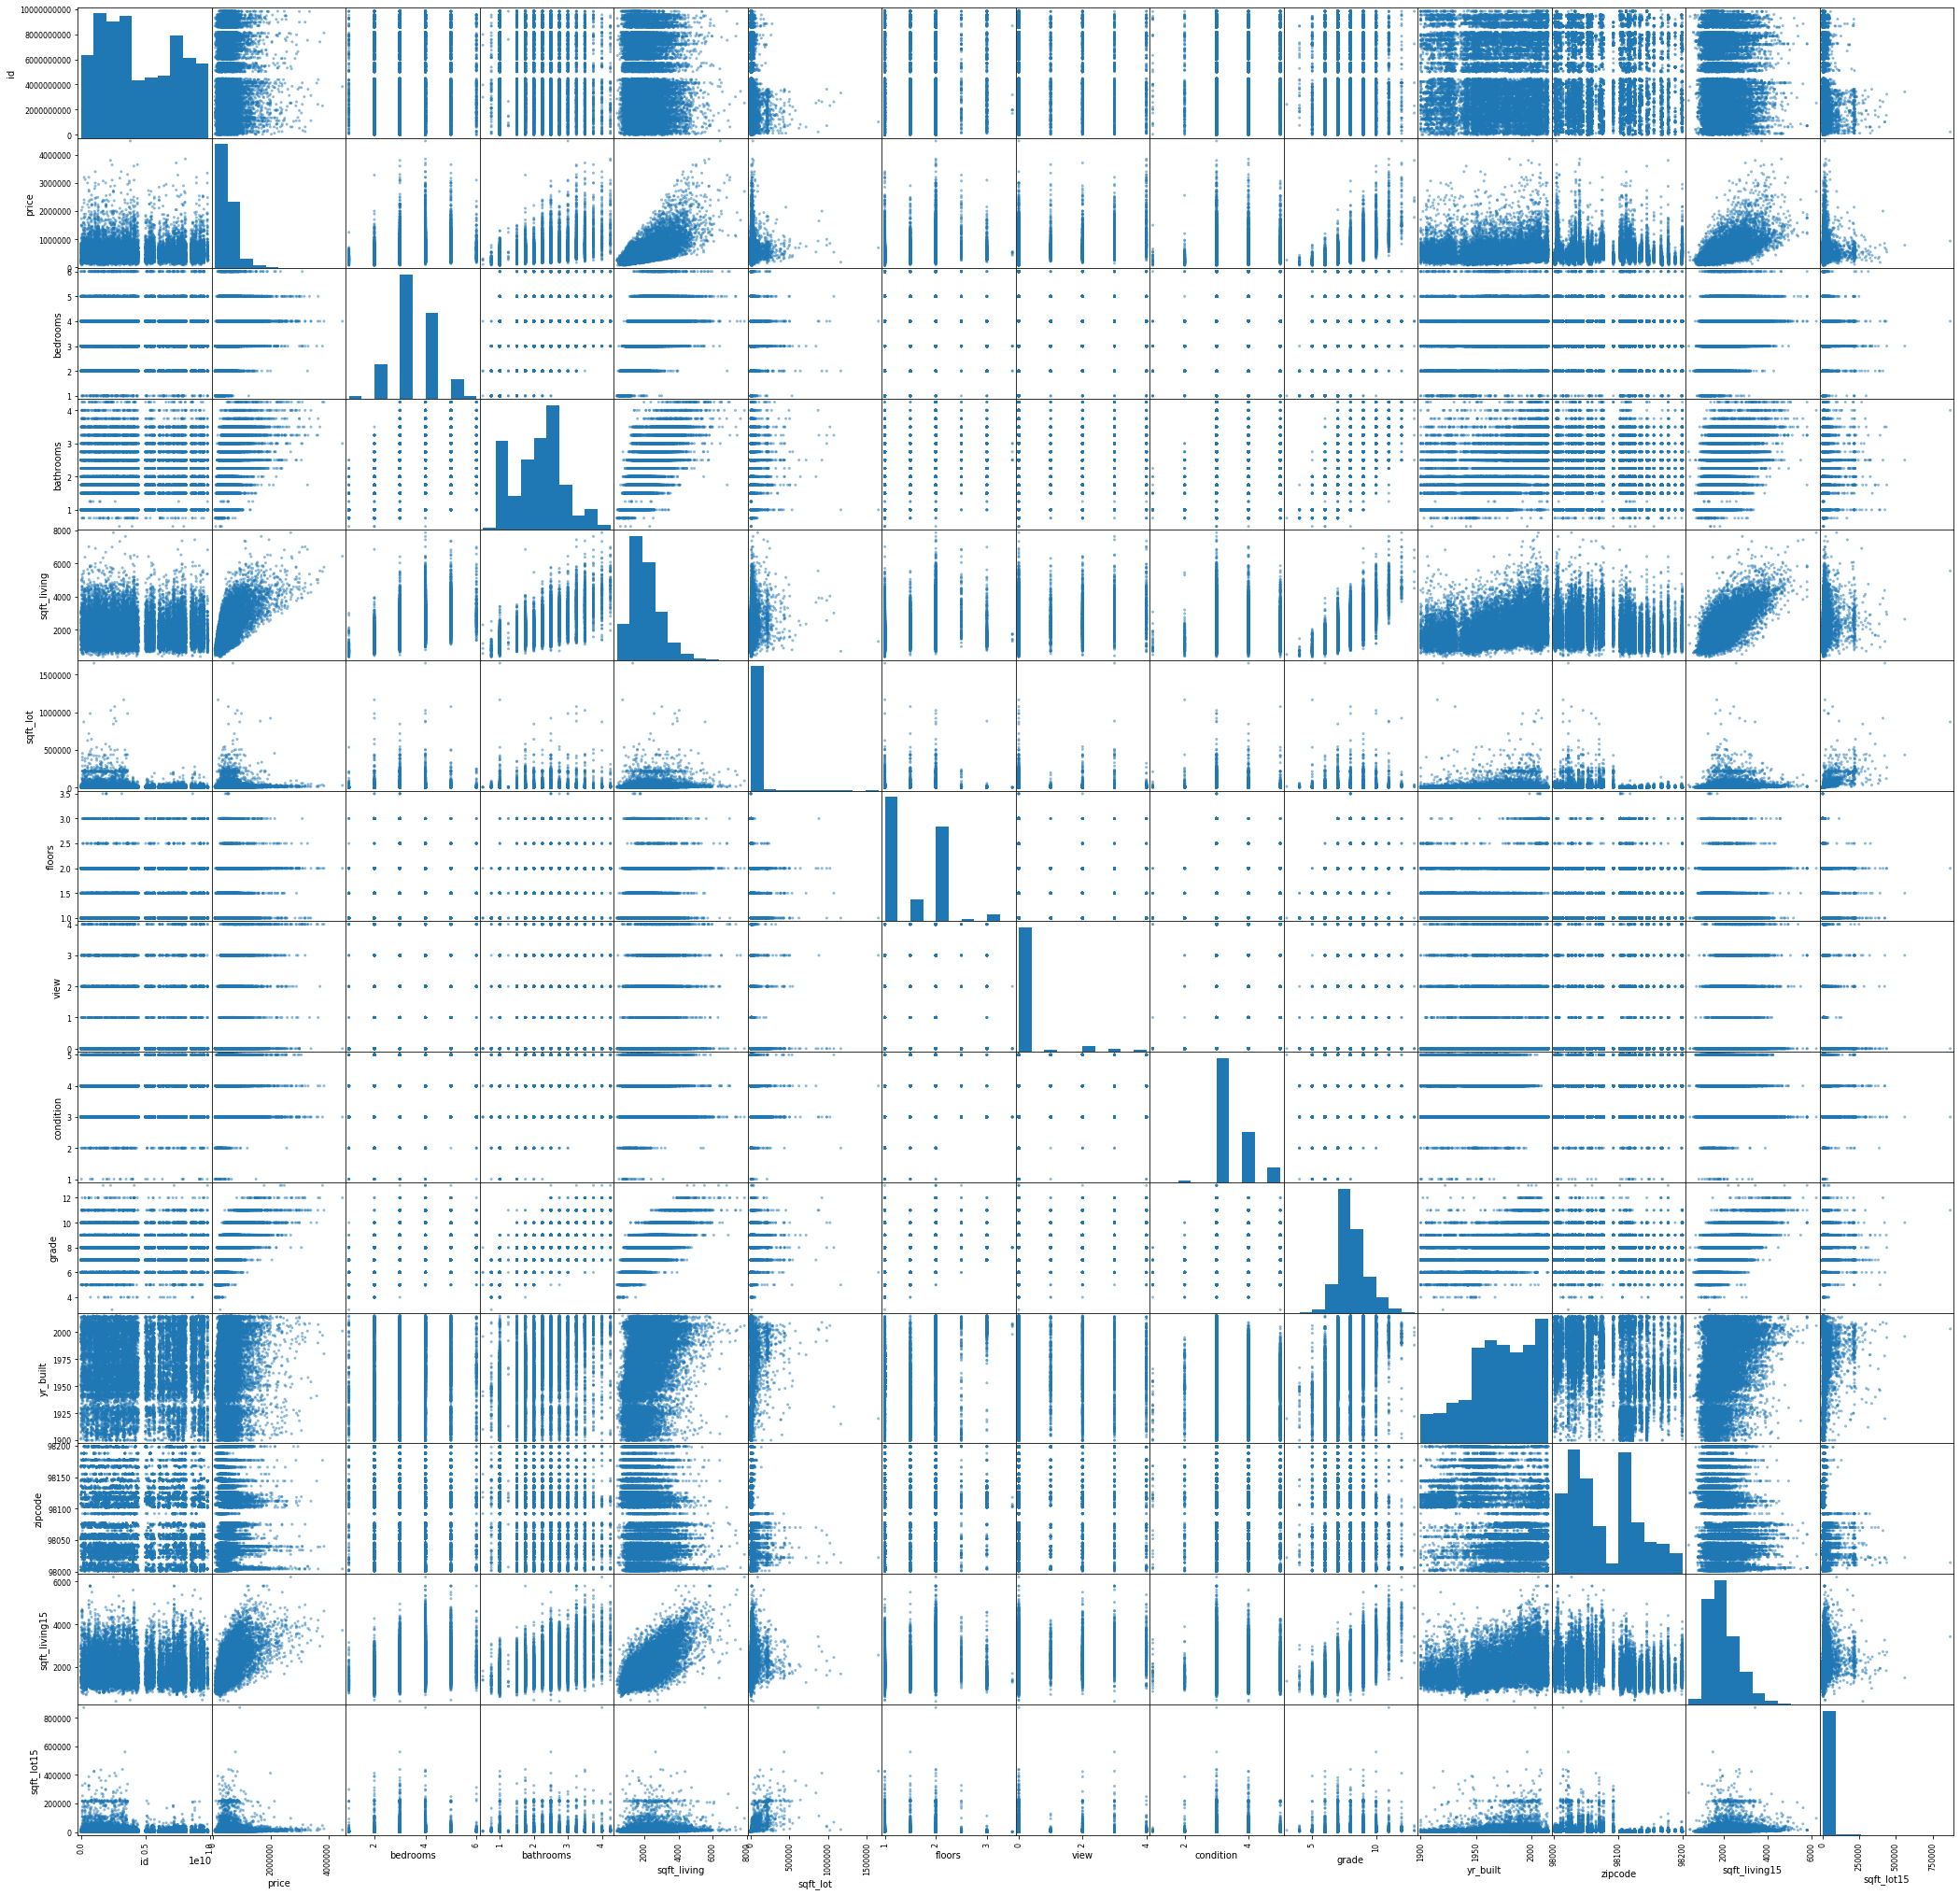

In [15]:
pd.plotting.scatter_matrix(cleaned_KC,alpha=0.5,figsize=(36,36))

In [16]:
categorical_features = ['bathrooms','bedrooms','zipcode','yr_built','grade','condition','view','floors']

In [17]:
for feature in categorical_features:
    cleaned_KC[feature] = cleaned_KC[feature].astype('category')
cleaned_KC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21301 entries, 0 to 21347
Data columns (total 15 columns):
id               21301 non-null int64
date             21301 non-null object
price            21301 non-null float64
bedrooms         21301 non-null category
bathrooms        21301 non-null category
sqft_living      21301 non-null int64
sqft_lot         21301 non-null int64
floors           21301 non-null category
view             21301 non-null category
condition        21301 non-null category
grade            21301 non-null category
yr_built         21301 non-null category
zipcode          21301 non-null category
sqft_living15    21301 non-null int64
sqft_lot15       21301 non-null int64
dtypes: category(8), float64(1), int64(5), object(1)
memory usage: 1.5+ MB


Since 'bathrooms' are now a category type, it would not be plotted in the scatter matrix

In [18]:
cleaned_KC.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,yr_built,zipcode,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955,98178,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951,98125,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933,98028,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965,98136,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987,98074,1800,7503


In [19]:
dummy_cleaned_KC = pd.get_dummies(cleaned_KC,columns=categorical_features)
dummy_cleaned_KC

,id,date,price,sqft_living,sqft_lot,sqft_living15,sqft_lot15,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,yr_built_1900,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,condition_1,condition_2,condition_3,condition_4,condition_5,view_0.0,view_1.0,view_2.0,view_3.0,view_4.0,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
0,7129300520,10/13/2014,221900.0,1180,5650,1340,5650,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,2570,7242,1690,7639,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

sqft_living has a positive correlation with price
bathrooms has a positive correlation with price
sqft_living15 has a positive correlation with price

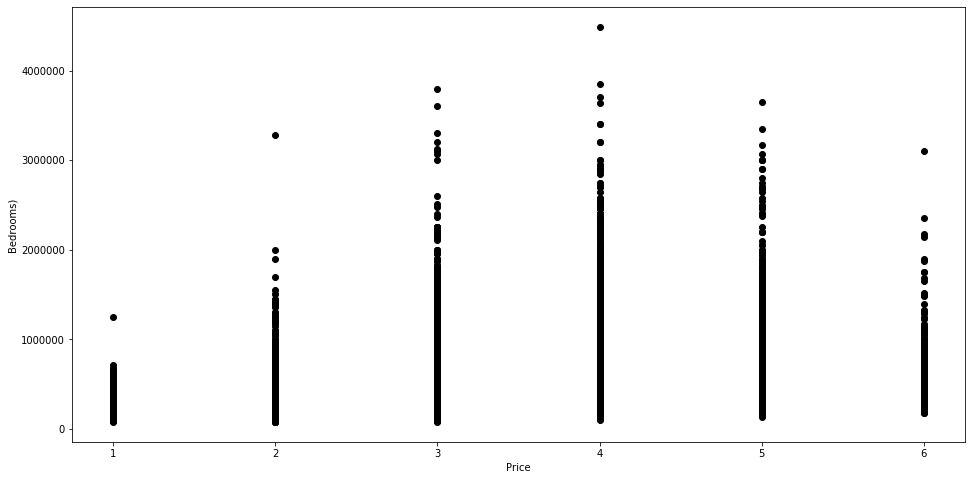

In [20]:
plt.figure(figsize=(16, 8))
plt.scatter(
    cleaned_KC['bedrooms'],
    cleaned_KC['price'],
    c='black'
)
plt.xlabel("Price")
plt.ylabel("Bedrooms)")
plt.show()

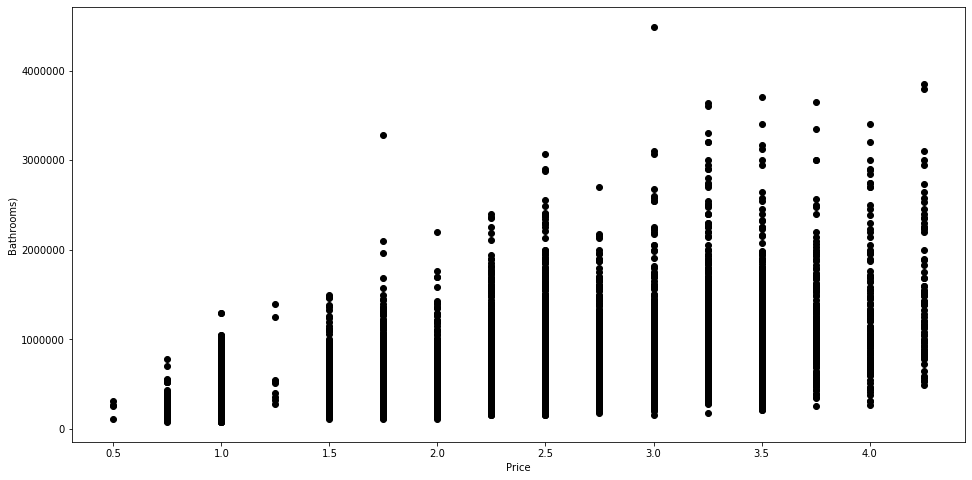

In [21]:
plt.figure(figsize=(16, 8))
plt.scatter(
    cleaned_KC['bathrooms'],
    cleaned_KC['price'],
    c='black'
)
plt.xlabel("Price")
plt.ylabel("Bathrooms)")
plt.show()

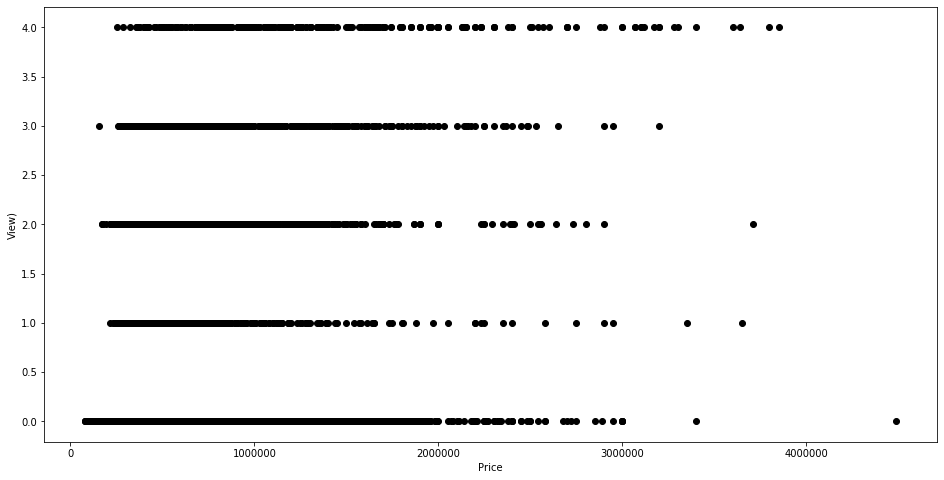

In [22]:
plt.figure(figsize=(16, 8))
plt.scatter(
    cleaned_KC['price'],
    cleaned_KC['view'],
    c='black'
)
plt.xlabel("Price")
plt.ylabel("View)")
plt.show()

In [23]:
cleaned_KC['view'].value_counts()

0.0    19266
2.0      930
3.0      487
1.0      325
4.0      293
Name: view, dtype: int64

In [25]:
X = cleaned_KC['sqft_living'].values.reshape(-1,1)
y = cleaned_KC['price'].values.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)

predictions = reg.predict(X)

X = cleaned_KC['sqft_living']
y = cleaned_KC['price']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                 1.806e+04
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:15:38   Log-Likelihood:            -2.9433e+05
No. Observations:               21301   AIC:                         5.887e+05
Df Residuals:                   21299   BIC:                         5.887e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2283.2967   4289.244     -0.532      

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


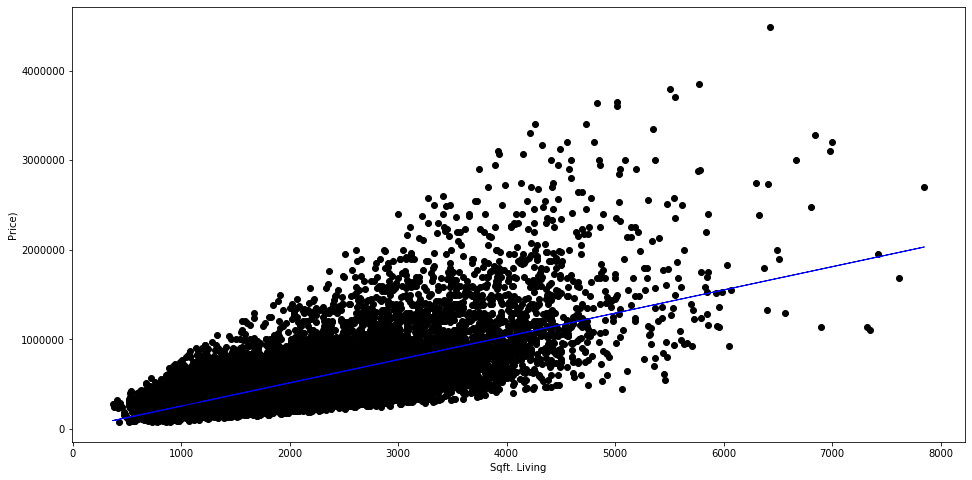

In [26]:
plt.figure(figsize=(16, 8))
plt.scatter(
    cleaned_KC['sqft_living'],
    cleaned_KC['price'],
    c='black'
)
plt.plot(
    cleaned_KC['sqft_living'],
    predictions,
    c='blue',
    linewidth=1
)
plt.xlabel("Sqft. Living")
plt.ylabel("Price)")
plt.show()

Let's now run multiple regressions

In [27]:
categorical_features = ['bedrooms','bathrooms','zipcode','yr_built','grade','condition','view','floors']

In [28]:
X = np.column_stack((cleaned_KC['sqft_living'], cleaned_KC['bedrooms'], cleaned_KC['bathrooms'], cleaned_KC['yr_built'],cleaned_KC['zipcode'],cleaned_KC['grade'], cleaned_KC['condition'], cleaned_KC['view'], cleaned_KC['floors']))
y = cleaned_KC['price']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary(xname=['price','sqft_living','bedrooms','bathrooms','zipcode','yr_built','grade','condition','view','floors']))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     3996.
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:16:01   Log-Likelihood:            -2.9033e+05
No. Observations:               21301   AIC:                         5.807e+05
Df Residuals:                   21291   BIC:                         5.808e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
price        8.165e+06   2.83e+06      2.886      

Previous R-squared & Adj. R-Squared = .52
New R-square value = .628

In [29]:
cleaned_KC.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,yr_built,zipcode,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955,98178,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951,98125,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933,98028,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965,98136,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987,98074,1800,7503


In [31]:
numeric_cleaned_KC = cleaned_KC._get_numeric_data()
numeric_cleaned_KC = numeric_cleaned_KC.drop(axis=1, columns='sqft_living15')

In [32]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(numeric_cleaned_KC.values, i) for i in range(numeric_cleaned_KC.shape[1])]
vif["features"] = numeric_cleaned_KC.columns

In [33]:
vif.round(1)

,VIF Factor,features
0,2.6,id
1,6.6,price
2,8.9,sqft_living
3,2.3,sqft_lot
4,2.5,sqft_lot15


Sqft_living and sqft_living15 are thought to have multi-collinearity, thus should both be dropped

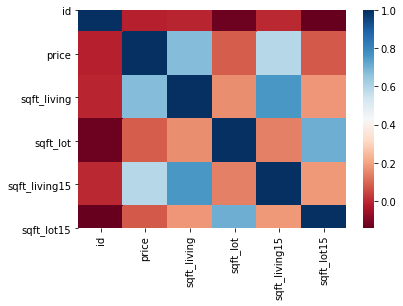

In [42]:
sns.heatmap(cleaned_KC.corr(), cmap="RdBu")